In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras import layers, models, optimizers
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import tensorflow as tf
import json
import gzip
import re
import langid
import seaborn as sns

# Data Cleaning 

In [2]:
def load_dataset_from_gzip(file_path):
    data = []
    with gzip.open(file_path, 'rt', encoding='utf-8') as fp:
        for line in fp:
            data.append(json.loads(line.strip()))
    return pd.DataFrame(data)

In [3]:
df = load_dataset_from_gzip('Appliances.jsonl.gz')

In [4]:
# drop non-review columns
df = df.drop(['images', 'asin', 'parent_asin', 'user_id', 'timestamp', 'helpful_vote'], axis = 1)
# only use verified purchases to reduce noise
df = df[df['verified_purchase'] == True]
# merge title and review and remove special characters
df['cleaned_text'] = (df['title'] + " " + df['text']).apply(lambda x: re.sub(r'[^a-zA-Z0-9\s]', '', x))
df = df[['cleaned_text', 'rating']]

In [5]:
df 

,cleaned_text,rating
0,Work great work great use a new one every month,5.0
1,excellent product Little on the thin side,5.0
2,Happy customer Quick delivery fixed the issue,5.0
3,Amazing value I wasnt sure whether these were ...,5.0
4,Dryer parts Easy to install got the product ex...,5.0
...,...,...
2128600,Accurate description As described,5.0
2128601,Not compatible with Nespresso U Machine I have...,3.0
2128602,Works with Sears Kenmore model 36275585891 Exa...,5.0
2128603,Perfect little ice maker Love this It doesnt k...,5.0


In [6]:
eng = df.copy()

In [7]:
def map_ratings_to_sentiment(rating):
    if rating >= 4:
        return 1  # Positive
    else:
        return 0  # Negative


In [8]:
eng['sentiment'] = eng['rating'].apply(map_ratings_to_sentiment)
eng = eng.drop(['rating'], axis =1)

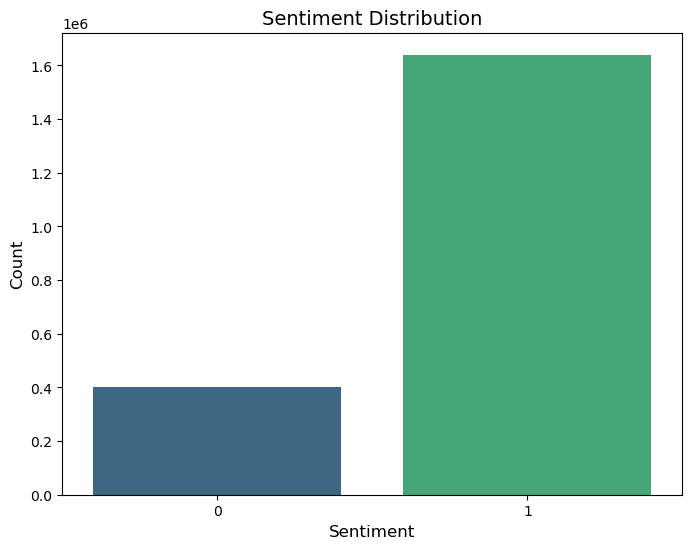

In [11]:
sentiment_counts = eng['sentiment'].value_counts()
plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')

# Add labels and title
plt.xlabel('Sentiment', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Sentiment Distribution', fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Show the plot
plt.show()

In [12]:
positive_samples = eng[eng['sentiment'] == 0].sample(n=100000, random_state=42)
negative_samples = eng[eng['sentiment'] == 1].sample(n=100000, random_state=42)

# Combine the two samples into a new DataFrame
balanced_df = pd.concat([positive_samples, negative_samples])

In [13]:
balanced_df = balanced_df[balanced_df['cleaned_text'].apply(lambda x: langid.classify(x)[0] == 'en')]

In [14]:
balanced_df.to_csv('english_reviews.csv', index=False)